In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt 



In [36]:
train_df = pd.read_csv('african-credit-scoring-challenge20241129-14702-1nqro8v/Train.csv')
test_df = pd.read_csv('african-credit-scoring-challenge20241129-14702-1nqro8v/Test.csv')
econ_df = pd.read_csv('african-credit-scoring-challenge20241129-14702-1nqro8v/economic_indicators.csv')

In [37]:
df = pd.concat([train_df, test_df])

In [38]:
train_ids = train_df['ID']
test_ids = test_df['ID']

In [39]:
def id_transform(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts all columns containing 'id' in their names to the 'object' dtype.

    Parameters:
    df (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with 'id' columns converted to 'object'.
    """
    # Create a dictionary of columns with 'id' and their target dtype
    id_maps = {col: 'object' for col in df.columns if 'id' in col}
    
    for col, dtype in id_maps.items():
        df[col] = df[col].astype(dtype)
    
    return df

In [40]:
def lender_loan_map(df: pd.DataFrame) -> pd.DataFrame:
    """
    Maps lender IDs and loan types in the DataFrame to simplified or anonymized representations.
    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing at least the columns 'lender_id' and 'loan_type'.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame with the 'lender_id' column mapped to a format like 'lender_A', 'lender_B', etc.,
        and the 'loan_type' column mapped to a single-character representation based on its numeric suffix.
    """
    
    # Create a mapping for 'lender_id' 
    lender_map = {
        name: f'lender_{chr(idx + ord("A"))}'  # chr(idx + ord('A')) converts 0 -> 'A', 1 -> 'B', etc.
        for idx, name in enumerate(df['lender_id'].unique())
    }

    # Create a mapping for 'loan_type' 
    loan_map = {
        loan_type: chr(ord('A') + int(loan_type.split('_')[1]))  # Extracts the numeric part and converts it to 'A', 'B', etc.
        for loan_type in df['loan_type'].unique()
    }

    df['lender_id'] = df['lender_id'].map(lender_map)
    df['loan_type'] = df['loan_type'].map(loan_map)
    
    df['pct_repay'] = df['Total_Amount_to_Repay'] / df['Total_Amount']
    df['repay_rate'] = df['Total_Amount_to_Repay'] / df['duration']
    
    return df


In [41]:
def date_treatment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the 'disbursement_date' column in the DataFrame to extract various date components
    and create additional features related to the date.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing at least the 'disbursement_date' column with date values.

    Returns:
    --------
    pandas.DataFrame
        The original DataFrame with added columns for year, month, day, day of the week, 
        day of the year, and a cohort identifier in 'YYYY-MM' format, and the days since the last loan..
    """
    
    df['disbursement_date'] = pd.to_datetime(df['disbursement_date'])
    df['dis_year'] = df['disbursement_date'].dt.year
    df['dis_month'] = df['disbursement_date'].dt.month
    df['dis_day'] = df['disbursement_date'].dt.day
    df['dis_day_of_week'] = df['disbursement_date'].dt.day_of_week
    df['dis_day_of_year'] = df['disbursement_date'].dt.day_of_year
    df['cohort'] = df['disbursement_date'].dt.strftime('%Y-%m')
    
    df = df.sort_values(by=['customer_id', 'disbursement_date'])
    df['days_since_last_loan'] = (
    df.groupby('customer_id')['disbursement_date']
        .diff()
        .dt.days
        .fillna(0)
        .astype(int)
    )
    
    return df.sort_index()

In [42]:
def analyze_refinancing(df):
    """
    Analyzes loan refinancing patterns by identifying duplicate loan IDs and calculating
    refinancing metrics when the lender changes.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing loan data with columns:
        - tbl_loan_id: Unique loan identifier
        - lender_id: Identifier for the lender
        - Amount_Funded_By_Lender: Loan amount
        - Lender_portion_Funded: Risk portion
        - customer_id: Unique customer identifier
    
    Returns:
    pandas.DataFrame: Original dataframe with added columns:
        - refinanced: Binary indicator (1 if refinanced)
        - refinance_amount: Change in loan amount after refinancing
        - increased_risk: Change in lender risk portion
    """    
    df_copy = df.reset_index()
    duplicate_loan_ids = df_copy['tbl_loan_id'].value_counts()[df_copy['tbl_loan_id'].value_counts() > 1].index
    # duplicate_loan_ids = df_copy['tbl_loan_id'][df_copy['tbl_loan_id'].duplicated(keep=False)]

    filtered_df = (df_copy[df_copy['tbl_loan_id'].isin(duplicate_loan_ids)].sort_values(['tbl_loan_id', 'customer_id']))

    refinance_col = ['refinanced', 'refinance_amount','increased_risk']
    for col in refinance_col:
            filtered_df[col] = np.nan

    shifted_df = filtered_df.shift(-1)

    same_loan_mask = filtered_df['tbl_loan_id'] == shifted_df['tbl_loan_id']
    different_lender_mask = filtered_df['lender_id'] != shifted_df['lender_id']
    refinance_mask = same_loan_mask & different_lender_mask

    # Calculate refinancing metrics
    filtered_df.loc[refinance_mask, 'refinanced'] = 1
    filtered_df.loc[refinance_mask.index, 'refinance_amount'] = (
        shifted_df.loc[refinance_mask.index,'Amount_Funded_By_Lender'] - 
        filtered_df.loc[refinance_mask.index,'Amount_Funded_By_Lender']
    )
    filtered_df.loc[refinance_mask.index, 'increased_risk'] = (
        shifted_df.loc[refinance_mask.index,'Lender_portion_Funded'] - 
        filtered_df.loc[refinance_mask.index,'Lender_portion_Funded']
    )
    filtered_df['refinanced'].ffill(inplace=True, axis=0)
    filtered_df['refinance_amount'].ffill(inplace=True, axis=0)
    filtered_df['increased_risk'].ffill(inplace=True, axis=0)

    merged_df = pd.concat([df_copy, filtered_df[refinance_col]], axis=1)

    merged_df.set_index('index', inplace=True)
    # merged_df.index.name=None
    merged_df.fillna(0, inplace=True)

    return merged_df

In [43]:
# def customer_mapping(df: pd.DataFrame) -> pd.DataFrame:
#     customer_map = {value:idx for idx, value in enumerate(df['New_versus_Repeat'].unique())}
#     df['New_versus_Repeat'] = df['New_versus_Repeat'].map(customer_map)


In [44]:
def customer_rfm(df: pd.DataFrame, col_map: dict) -> pd.DataFrame:
    
    last_day = df['disbursement_date'].max()
    recency = df[['customer_id','disbursement_date']]
    recency['recency'] = (last_day - recency['disbursement_date']).dt.days
    recency_pivot = recency.groupby('customer_id')['recency'].min().reset_index()
    
    customer_map = {value:idx for idx, value in enumerate(df['New_versus_Repeat'].unique())}
    df['New_versus_Repeat'] = df['New_versus_Repeat'].map(customer_map).astype(int)
    
    df.rename(columns={'New_versus_Repeat' : 'new', 'Total_Amount':'monetary', 'ID':'frequency', 'Lender_portion_Funded' : 'lender_portion'}, inplace=True)  
    
    customer_df = df.groupby('customer_id').agg(col_map).reset_index()
    customer_df = customer_df.merge(right= recency_pivot, how='left', on='customer_id')
    
    return customer_df

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from typing import Optional

def rfm_clusters(df: pd.DataFrame, cols_to_transform: list, col_map: dict, best_k:int, display_diagnostics:bool = False, diagnostics: Optional[list[str]] = None) -> pd.DataFrame:
    customer_df = customer_rfm(df, col_map)
    
    customer_df[cols_to_transform] = np.log1p(customer_df[cols_to_transform])
    X = customer_df.drop(columns=['customer_id', 'target']).fillna(0)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    if display_diagnostics:
        if diagnostics is None or 'silhouette' in diagnostics:
            silhouette_scores = []
            k_values = range(2, 11)  

            for k in k_values:
                kmeans = KMeans(n_clusters=k, random_state=42)
                cluster_labels = kmeans.fit_predict(X)
                
                # Compute silhouette score
                score = silhouette_score(X, cluster_labels)
                silhouette_scores.append(score)

            # 4. Plot silhouette scores
            plt.figure(figsize=(10, 6))
            plt.plot(k_values, silhouette_scores, marker='o')
            plt.title("Silhouette Method: Optimal Number of Clusters")
            plt.xlabel("Number of Clusters (k)")
            plt.ylabel("Silhouette Score")
            plt.xticks(k_values)
            plt.grid()
            plt.show()
        
        if diagnostics is None or 'elbow' in diagnostics:
            inertia = []
            k_range = range(1, 11)  # test for 1 to 10 clusters
            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42)
                kmeans.fit(X)
                inertia.append(kmeans.inertia_)

            # Step 3: Plot the inertia values to visualize the elbow
            plt.plot(k_range, inertia, marker='o')
            plt.title("Elbow Method For Optimal k")
            plt.xlabel("Number of Clusters (k)")
            plt.ylabel("Inertia")
            plt.show()
    
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    clusters = kmeans.fit_predict(X)
    customer_df['cluster'] = clusters
    
    return customer_df

In [46]:
df = pd.concat([train_df, test_df])

df = id_transform(df)
df = lender_loan_map(df)
df = date_treatment(df)
df = analyze_refinancing(df)
col_map = {
    'frequency' : 'count', 
    'monetary' : 'mean',
    'pct_repay' : 'mean',
    'repay_rate' : 'mean',
    'duration' : 'mean',
    'days_since_last_loan' : 'mean',
    'lender_portion' : 'mean',
    'new' : 'max',
    'refinanced' : 'mean',
    'refinance_amount' : 'mean',
    'increased_risk' : 'mean',
    'target' : 'mean'    
}

cols_to_transform = ['recency', 'monetary', 'repay_rate', 'duration', 'days_since_last_loan', 'lender_portion', 'refinance_amount']

customer_df = rfm_clusters(df, col_map=col_map, cols_to_transform=cols_to_transform, best_k=6, display_diagnostics=False)

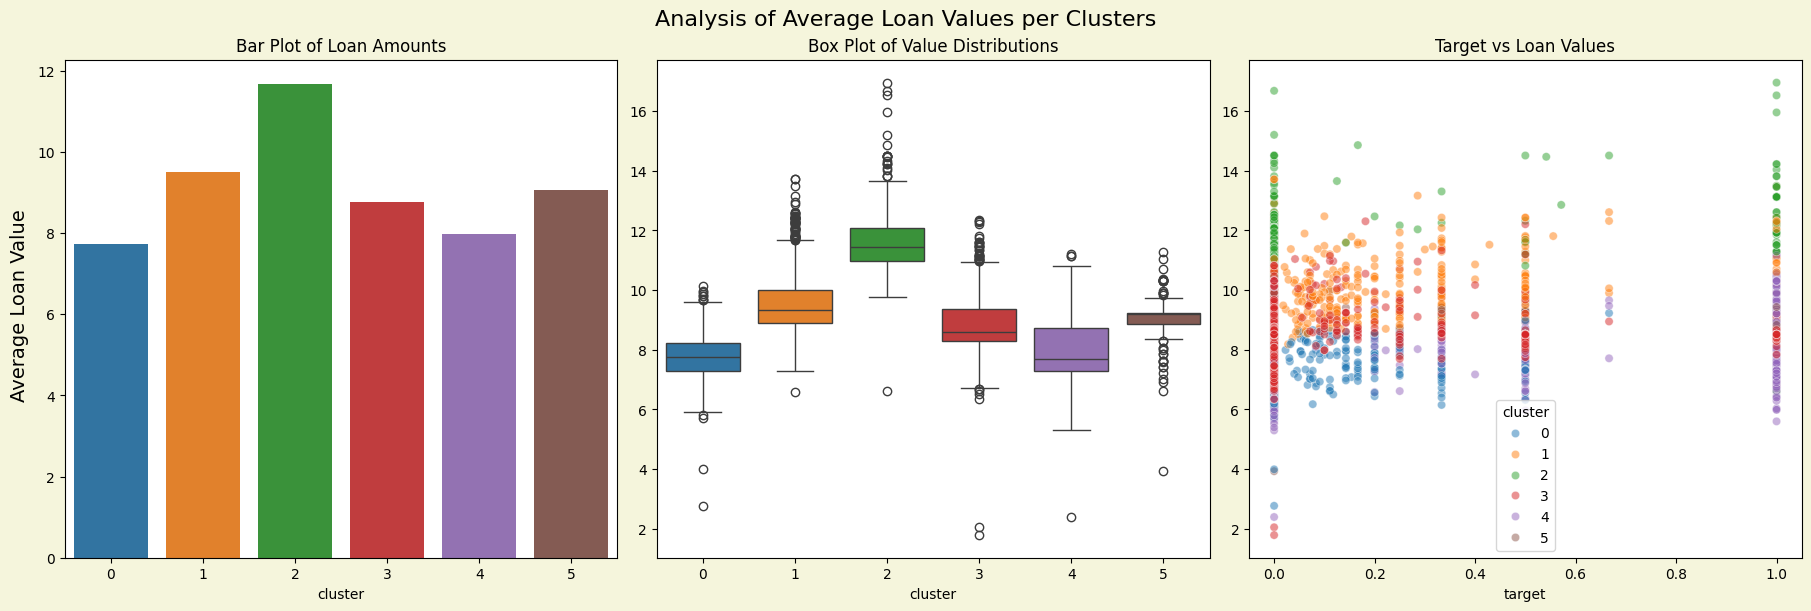

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), layout="constrained", facecolor="#F5F5DC")

fig.suptitle('Analysis of Average Loan Values per Clusters', fontsize=16)
fig.supylabel("Average Loan Value", fontsize=14)

sns.barplot(data=customer_df, x='cluster', y='monetary', palette='tab10', errorbar=None, ax=axs[0])
axs[0].set_title("Bar Plot of Loan Amounts", fontsize=12)

sns.boxplot(data=customer_df, x='cluster', y='monetary', palette='tab10', ax=axs[1])
axs[1].set_title("Box Plot of Value Distributions", fontsize=12)

sns.scatterplot(data=customer_df, x='target', y='monetary', hue='cluster', palette='tab10', alpha=0.5, ax=axs[2])
axs[2].set_title("Target vs Loan Values", fontsize=12)

for ax in axs:
    ax.set_ylabel('')

plt.show()

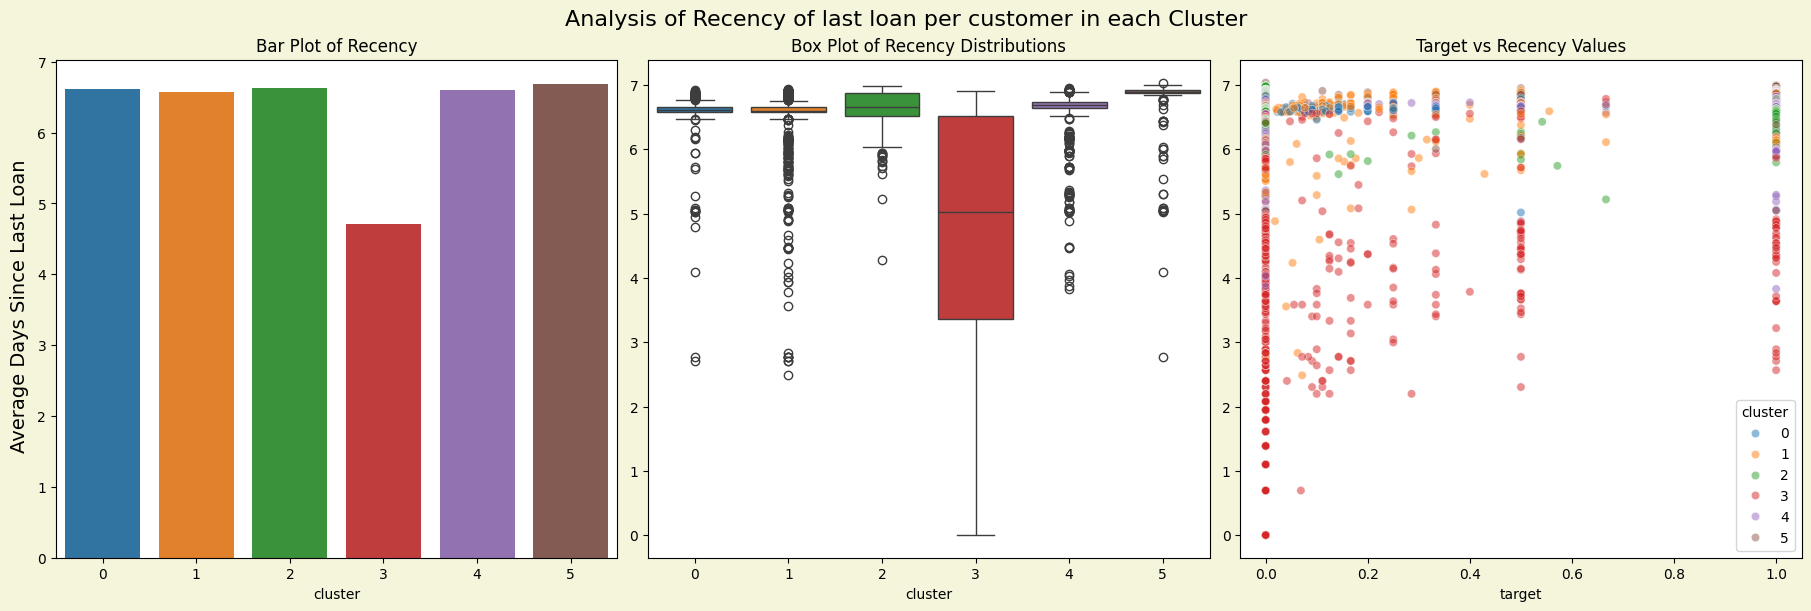

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), layout="constrained", facecolor="#F5F5DC")

fig.suptitle('Analysis of Recency of last loan per customer in each Cluster', fontsize=16)
fig.supylabel("Average Days Since Last Loan", fontsize=14)

sns.barplot(data=customer_df, x='cluster', y='recency', palette='tab10', errorbar=None, ax=axs[0])
axs[0].set_title("Bar Plot of Recency", fontsize=12)

sns.boxplot(data=customer_df, x='cluster', y='recency', palette='tab10', ax=axs[1])
axs[1].set_title("Box Plot of Recency Distributions", fontsize=12)

sns.scatterplot(data=customer_df, x='target', y='recency', hue='cluster', palette='tab10', alpha=0.5, ax=axs[2])
axs[2].set_title("Target vs Recency Values", fontsize=12)

for ax in axs:
    ax.set_ylabel('')

plt.show()


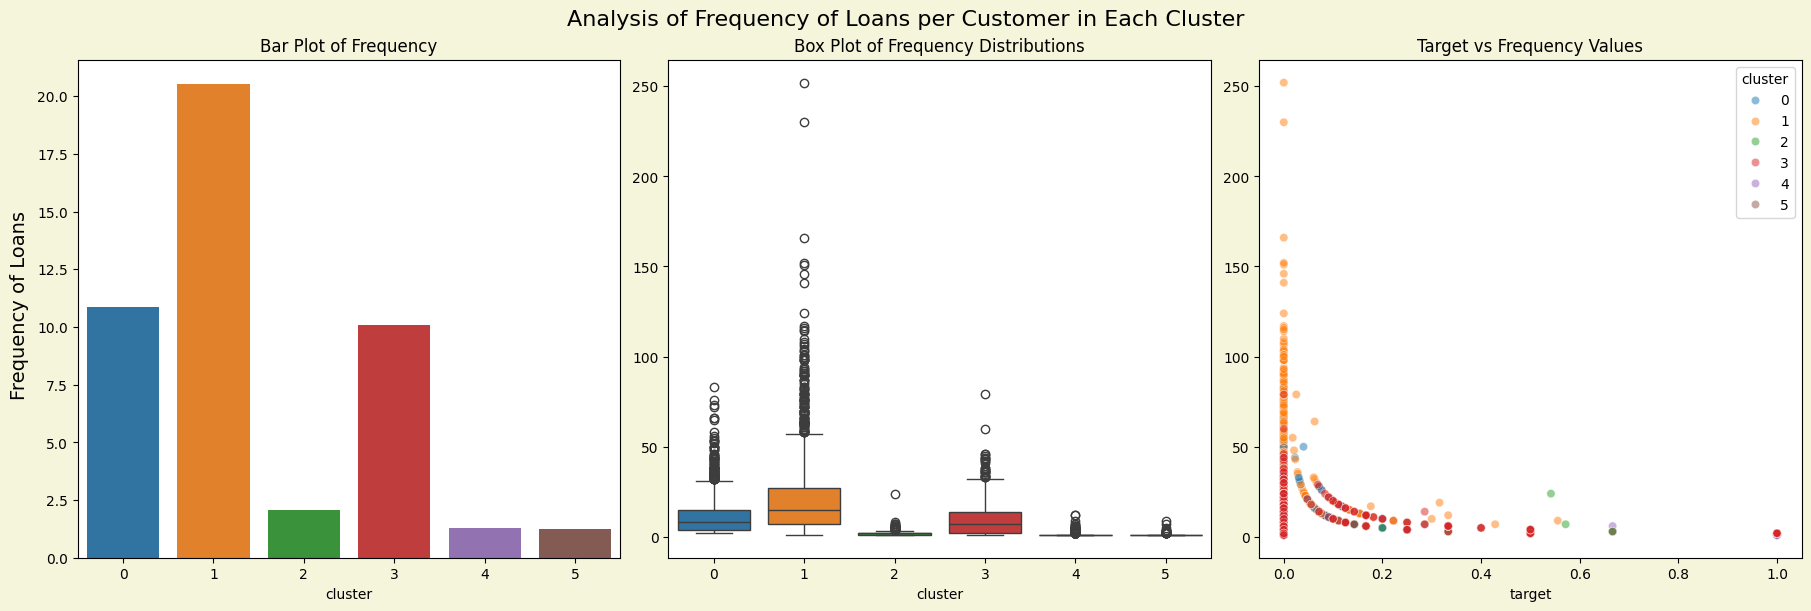

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), layout="constrained", facecolor="#F5F5DC")

# Figure-level titles
fig.suptitle('Analysis of Frequency of Loans per Customer in Each Cluster', fontsize=16)
fig.supylabel("Frequency of Loans", fontsize=14)

# Bar Plot: Average frequency of loans per cluster
sns.barplot(data=customer_df, x='cluster', y='frequency', palette='tab10', errorbar=None, ax=axs[0])
axs[0].set_title("Bar Plot of Frequency", fontsize=12)

# Box Plot: Distribution of frequency within each cluster
sns.boxplot(data=customer_df, x='cluster', y='frequency', palette='tab10', ax=axs[1])
axs[1].set_title("Box Plot of Frequency Distributions", fontsize=12)

# Scatter Plot: Target vs. frequency with cluster as hue
sns.scatterplot(data=customer_df, x='target', y='frequency', hue='cluster', palette='tab10', alpha=0.5, ax=axs[2])
axs[2].set_title("Target vs Frequency Values", fontsize=12)

# Remove individual y-axis labels for clarity
for ax in axs:
    ax.set_ylabel('')

# Display the plots
plt.show()


In [50]:
customer_df.groupby(['cluster', 'new']).agg({'customer_id' : 'count', 'frequency' : 'mean', 'monetary' : 'mean', 'recency' : 'mean', 'pct_repay' : 'mean', 'new': 'mean', 'target' :'mean'})

customer_id  frequency   monetary   recency  pct_repay  new  \
cluster new                                                                
0       0           2263  11.089262   7.730670  6.614584   1.030041  0.0   
        1            164   7.969512   7.644074  6.622638   1.039342  1.0   
1       0           2427  20.705398   9.500931  6.564330   1.029661  0.0   
        1             46  11.869565   9.719785  6.622791   1.031932  1.0   
2       0            292   2.113014  11.725854  6.638902   1.267525  0.0   
        1             44   1.750000  11.363876  6.597076   1.262779  1.0   
3       0            535  10.682243   8.809142  4.853250   1.059956  0.0   
        1            240   8.816667   8.640002  4.370055   1.060459  1.0   
4       0            874   1.233410   8.014512  6.602660   1.144836  0.0   
        1            131   1.687023   7.654999  6.635576   1.143634  1.0   
5       0             69   1.246377   8.962023  6.517542   1.139009  0.0   
        1            111   1.243243   9.131856  6.795662   1.113540  1.0   

               target  
cluster new            
0       0    0.013814  
        1    0.019200  
1       0    0.030759  
        1    0.034987  
2       0    0.143746  
        1    0.116883  
3       0    0.084346  
        1    0.159822  
4       0    0.197664  
        1    0.187786  
5       0    0.080975  
        1    0.633934

In [51]:
customer_df.groupby('cluster').agg({'customer_id' : 'count', 'frequency' : 'mean', 'monetary' : 'mean', 'recency' : 'mean', 'pct_repay' : 'mean', 'new': 'mean', 'target' :'mean'})

,customer_id,frequency,monetary,recency,pct_repay,new,target
cluster,,,,,,,
0,2427,10.878451,7.724818,6.615129,1.030669,0.067573,0.014178
1,2473,20.541043,9.505002,6.565418,1.029704,0.018601,0.030838
2,336,2.065476,11.678452,6.633424,1.266904,0.130952,0.140228
3,775,10.104516,8.756763,4.703615,1.060111,0.309677,0.107719
4,1005,1.292537,7.967650,6.606950,1.144679,0.130348,0.196376
5,180,1.244444,9.066753,6.689049,1.123303,0.616667,0.421966


In [52]:
def bin_features(df: pd.DataFrame, vectorize_bins: bool = True) -> pd.DataFrame:
    # Define bins
    duration_bins = [0,6,7,14,30,90,180,360,540,720, np.inf]
    portion_bins = [0, 0.12, 0.2,0.25, 0.3, 0.37, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, np.inf]
    amount_bins = [0, 10, 100, 315, 1000, 2295, 5000, 7500, 10000, 11450, 15000,25000, 50000, 100000, 119411, np.inf]

    # Create binned columns
    df['binned_lender_portion'] = pd.cut(df['lender_portion'], bins=portion_bins)
    df['binned_duration'] = pd.cut(df['duration'], bins=duration_bins)
    df['binned_amounts'] = pd.cut(df['Total_Amount_to_Repay'], bins=amount_bins)
    
    if vectorize_bins:
        # Calculate mean target for each combination
        bin_summary = df.groupby(['binned_lender_portion', 'binned_duration', 'binned_amounts'])['target'].mean()
        
        # Create a mapping dictionary from bin combinations to their mean target
        bin_mapping = bin_summary.to_dict()
        
        # Create a new column with the combination
        df['bin_combination'] = df.apply(
            lambda x: (x['binned_lender_portion'], 
                      x['binned_duration'], 
                      x['binned_amounts']), 
            axis=1
        )
        
        # Map the combinations to their mean target values
        df['bin_score'] = df['bin_combination'].map(bin_mapping)
        
        # Drop the temporary combination column
        df = df.drop('bin_combination', axis=1)
    
    return df

In [53]:
from sklearn.ensemble import RandomForestRegressor

def lender_profile(
    df:pd.DataFrame,
    train_split: list[str],
    test_split: list[str],
    forecast_test: bool = True,
    ) -> pd.DataFrame:
    
    loan_lender_summary = df[df['frequency'].isin(train_split)].groupby(['lender_id', 'loan_type']).agg({
    'pct_repay': ['mean', 'std'],
    'repay_rate': ['mean', 'std'],
    'monetary': ['mean', 'std'],
    'lender_portion': ['mean','std'],
    'duration': ['mean','std'],
    'refinanced' : 'mean',
    'refinance_amount' : 'mean',
    'increased_risk' : 'mean',
    'target': 'mean' 
    }).reset_index()
    loan_lender_summary.columns = ['lender_id', 'loan_type', 'mean_pct_repay', 'std_pct_repay',
                                    'mean_repay_rate', 'std_repay_rate',
                                    'mean_loan_amount', 'std_loan_amount',
                                    'mean_portion', 'std_portion',
                                    'mean_duration', 'std_duration', 
                                   'refinanced', 'refinance_amount', 'increased_risk', 'default_rate', ] 
    
    if forecast_test:
        X = loan_lender_summary.drop(columns=['lender_id','loan_type','default_rate'])
        y = loan_lender_summary['default_rate']
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(np.log1p(X))
        y = loan_lender_summary['default_rate']

        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_scaled, y)
        
        X_test = df[df['frequency'].isin(test_split)].groupby(['lender_id', 'loan_type']).agg({
            'pct_repay': ['mean', 'std'],
            'repay_rate': ['mean', 'std'],
            'monetary': ['mean', 'std'],
            'lender_portion': ['mean','std'],
            'duration': ['mean','std'],
            'refinanced' : 'mean',
            'refinance_amount' : 'mean',
            'increased_risk' : 'mean',
            }).reset_index()
        
        
        X_test.columns = ['lender_id', 'loan_type', 'mean_pct_repay', 'std_pct_repay',
                            'mean_repay_rate', 'std_repay_rate',
                            'mean_loan_amount', 'std_loan_amount',
                            'mean_portion', 'std_portion',
                            'mean_duration', 'std_duration', 
                            'refinanced', 'refinance_amount', 'increased_risk']
        
        preds = rf.predict(X_test.drop(columns=['lender_id','loan_type']))
        X_test['default_rate'] = preds
        
        loan_lender_summary= pd.concat([loan_lender_summary, X_test])
        
    return loan_lender_summary

In [54]:
train_summary = df[df['frequency'].isin(train_ids)].groupby(['lender_id', 'loan_type']).agg({
    'pct_repay': ['mean', 'std'],
    'repay_rate': ['mean', 'std'],
    'monetary': ['mean', 'std'],
    'lender_portion': ['mean','std'],
    'duration': ['mean','std'],
    'refinanced': 'mean',
    'refinance_amount': 'mean',
    'increased_risk': 'mean',
    'target': 'mean'
}).reset_index()

train_summary.columns = ['lender_id', 'loan_type', 'mean_pct_repay', 'std_pct_repay',
                        'mean_repay_rate', 'std_repay_rate',
                        'mean_loan_amount', 'std_loan_amount',
                        'mean_portion', 'std_portion',
                        'mean_duration', 'std_duration',
                        'refinanced', 'refinance_amount', 'increased_risk', 'default_rate']

predicted_summary = lender_profile(df, train_ids, test_ids, forecast_test=True)

final_summary = train_summary.copy()
new_combinations = predicted_summary[
    ~predicted_summary[['lender_id', 'loan_type']].apply(tuple, 1).isin(
        train_summary[['lender_id', 'loan_type']].apply(tuple, 1)
    )
]
final_summary = pd.concat([final_summary, new_combinations])

columns_to_merge = ['lender_id', 'loan_type', 'mean_pct_repay','std_pct_repay','mean_repay_rate','mean_loan_amount','std_loan_amount','default_rate']
df = df.merge(
    final_summary[columns_to_merge],
    how='left',
    on=['lender_id', 'loan_type'],
    validate='many_to_one'
)


In [55]:
df = df.rename(columns={'frequency' : 'id'})
customer_cols = ['customer_id', 'frequency', 'recency', 'cluster' ]

df = df.merge(
    customer_df[customer_cols],
    how='left',
    on='customer_id'
)
df

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,monetary,Total_Amount_to_Repay,disbursement_date,due_date,...,increased_risk,mean_pct_repay,std_pct_repay,mean_repay_rate,mean_loan_amount,std_loan_amount,default_rate,frequency,recency,cluster
0,ID_266671248032267278,266671,Kenya,248032,lender_A,B,8448.0,8448.0,2022-08-30,2022-09-06,...,0.0,1.016809,0.048257,1387.825272,9561.219400,15894.413736,0.008425,73,6.579251,1
1,ID_269404226088267278,269404,Kenya,226088,lender_A,B,1919.0,1989.0,2022-07-27,2022-08-03,...,0.0,1.016809,0.048257,1387.825272,9561.219400,15894.413736,0.008425,2,6.716595,0
2,ID_255356300042267278,255356,Kenya,300042,lender_A,B,2138.0,2153.0,2022-11-16,2022-11-23,...,0.0,1.016809,0.048257,1387.825272,9561.219400,15894.413736,0.008425,152,6.579251,1
3,ID_248919228515267278,248919,Kenya,228515,lender_A,B,25895.0,25979.0,2022-07-30,2022-08-06,...,0.0,1.016809,0.048257,1387.825272,9561.219400,15894.413736,0.008425,23,6.677083,1
4,ID_308486370501251804,308486,Kenya,370501,lender_B,H,6900.0,7142.0,2024-09-06,2024-09-13,...,0.0,1.041117,0.024511,1586.565982,10688.707194,14110.826374,0.084173,12,2.302585,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87243,ID_244559228408267278,244559,Kenya,228408,lender_A,B,1460.0,1515.0,2022-07-30,2022-08-06,...,0.0,1.016809,0.048257,1387.825272,9561.219400,15894.413736,0.008425,11,6.586172,0
87244,ID_260062217784267278,260062,Kenya,217784,lender_A,B,5029.0,5116.0,2022-07-16,2022-07-23,...,0.0,1.016809,0.048257,1387.825272,9561.219400,15894.413736,0.008425,18,6.605298,0
87245,ID_259137216701267278,259137,Kenya,216701,lender_A,B,5289.0,5289.0,2022-07-15,2022-07-22,...,0.0,1.016809,0.048257,1387.825272,9561.219400,15894.413736,0.008425,62,6.580639,1
87246,ID_266801303201267278,266801,Kenya,303201,lender_A,B,3334.0,3334.0,2022-11-23,2022-11-30,...,0.0,1.016809,0.048257,1387.825272,9561.219400,15894.413736,0.008425,54,6.576470,1


In [56]:
df = bin_features(df)
df['bin_score'].fillna(df['bin_score'].mean(), inplace=True)
df

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,monetary,Total_Amount_to_Repay,disbursement_date,due_date,...,mean_loan_amount,std_loan_amount,default_rate,frequency,recency,cluster,binned_lender_portion,binned_duration,binned_amounts,bin_score
0,ID_266671248032267278,266671,Kenya,248032,lender_A,B,8448.0,8448.0,2022-08-30,2022-09-06,...,9561.219400,15894.413736,0.008425,73,6.579251,1,"(0.0, 0.12]","(6.0, 7.0]","(7500.0, 10000.0]",0.006931
1,ID_269404226088267278,269404,Kenya,226088,lender_A,B,1919.0,1989.0,2022-07-27,2022-08-03,...,9561.219400,15894.413736,0.008425,2,6.716595,0,"(0.25, 0.3]","(6.0, 7.0]","(1000.0, 2295.0]",0.009571
2,ID_255356300042267278,255356,Kenya,300042,lender_A,B,2138.0,2153.0,2022-11-16,2022-11-23,...,9561.219400,15894.413736,0.008425,152,6.579251,1,NaN,"(6.0, 7.0]","(1000.0, 2295.0]",0.016368
3,ID_248919228515267278,248919,Kenya,228515,lender_A,B,25895.0,25979.0,2022-07-30,2022-08-06,...,9561.219400,15894.413736,0.008425,23,6.677083,1,"(0.25, 0.3]","(6.0, 7.0]","(25000.0, 50000.0]",0.009287
4,ID_308486370501251804,308486,Kenya,370501,lender_B,H,6900.0,7142.0,2024-09-06,2024-09-13,...,10688.707194,14110.826374,0.084173,12,2.302585,3,"(0.12, 0.2]","(6.0, 7.0]","(5000.0, 7500.0]",0.053952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87243,ID_244559228408267278,244559,Kenya,228408,lender_A,B,1460.0,1515.0,2022-07-30,2022-08-06,...,9561.219400,15894.413736,0.008425,11,6.586172,0,"(0.25, 0.3]","(6.0, 7.0]","(1000.0, 2295.0]",0.009571
87244,ID_260062217784267278,260062,Kenya,217784,lender_A,B,5029.0,5116.0,2022-07-16,2022-07-23,...,9561.219400,15894.413736,0.008425,18,6.605298,0,"(0.25, 0.3]","(6.0, 7.0]","(5000.0, 7500.0]",0.006840
87245,ID_259137216701267278,259137,Kenya,216701,lender_A,B,5289.0,5289.0,2022-07-15,2022-07-22,...,9561.219400,15894.413736,0.008425,62,6.580639,1,"(0.25, 0.3]","(6.0, 7.0]","(5000.0, 7500.0]",0.006840
87246,ID_266801303201267278,266801,Kenya,303201,lender_A,B,3334.0,3334.0,2022-11-23,2022-11-30,...,9561.219400,15894.413736,0.008425,54,6.576470,1,"(0.2, 0.25]","(6.0, 7.0]","(2295.0, 5000.0]",0.030303


In [57]:
df = df.rename(columns={col:col.lower() for col in df.columns})

In [63]:
df[df['id'].isin(train_ids)].to_csv('train_processed.csv', index=False)
df[df['id'].isin(test_ids)].to_csv('test_processed.csv', index=False)

In [61]:
df[df['id'].isin(test_ids)]

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,monetary,total_amount_to_repay,disbursement_date,due_date,...,mean_loan_amount,std_loan_amount,default_rate,frequency,recency,cluster,binned_lender_portion,binned_duration,binned_amounts,bin_score
1,ID_269404226088267278,269404,Kenya,226088,lender_A,B,1919.00,1989.00,2022-07-27,2022-08-03,...,9561.219400,15894.413736,0.008425,2,6.716595,0,"(0.25, 0.3]","(6.0, 7.0]","(1000.0, 2295.0]",0.009571
2,ID_255356300042267278,255356,Kenya,300042,lender_A,B,2138.00,2153.00,2022-11-16,2022-11-23,...,9561.219400,15894.413736,0.008425,152,6.579251,1,NaN,"(6.0, 7.0]","(1000.0, 2295.0]",0.016368
5,ID_257026243764267278,257026,Kenya,243764,lender_A,B,8254.00,8304.00,2022-08-24,2022-08-31,...,9561.219400,15894.413736,0.008425,38,6.651572,1,"(0.0, 0.12]","(6.0, 7.0]","(7500.0, 10000.0]",0.006931
6,ID_264617299409267278,264617,Kenya,299409,lender_A,B,3379.00,3379.00,2022-11-15,2022-11-22,...,9561.219400,15894.413736,0.008425,43,6.576470,1,"(0.25, 0.3]","(6.0, 7.0]","(2295.0, 5000.0]",0.007907
9,ID_247613296713267278,247613,Kenya,296713,lender_A,B,120.00,120.00,2022-11-10,2022-11-17,...,9561.219400,15894.413736,0.008425,252,6.579251,1,"(0.25, 0.3]","(6.0, 7.0]","(100.0, 315.0]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37178,ID_297596365331297183,297596,Ghana,365331,lender_E,D,1730.41,1782.32,2023-02-09,2023-02-16,...,3168.778418,2304.598521,0.656993,46,6.469250,3,"(0.12, 0.2]","(6.0, 7.0]","(1000.0, 2295.0]",0.003720
37181,ID_259715231897267278,259715,Kenya,231897,lender_A,B,1534.00,1534.00,2022-08-04,2022-08-11,...,9561.219400,15894.413736,0.008425,39,6.580639,1,"(0.25, 0.3]","(6.0, 7.0]","(1000.0, 2295.0]",0.009571
37183,ID_296701364008297183,296701,Ghana,364008,lender_E,D,1372.21,1413.30,2022-06-23,2022-06-30,...,3168.778418,2304.598521,0.656993,32,6.598509,3,"(0.12, 0.2]","(6.0, 7.0]","(1000.0, 2295.0]",0.003720
37185,ID_268271242864267278,268271,Kenya,242864,lender_A,B,5608.00,5781.00,2022-08-23,2022-08-30,...,9561.219400,15894.413736,0.008425,9,6.628041,0,NaN,"(6.0, 7.0]","(5000.0, 7500.0]",0.016368


In [62]:
test_df

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.00,1989.00,2022-07-27,2022-08-03,7,Repeat Loan,575.70,0.300000,597.00
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.00,2153.00,2022-11-16,2022-11-23,7,Repeat Loan,0.00,0.000000,0.00
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.00,8304.00,2022-08-24,2022-08-31,7,Repeat Loan,207.00,0.025079,208.00
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.00,3379.00,2022-11-15,2022-11-22,7,Repeat Loan,1013.70,0.300000,1014.00
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.00,120.00,2022-11-10,2022-11-17,7,Repeat Loan,36.00,0.300000,36.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,ID_297596365331297183,297596,Ghana,365331,297183,Type_3,1730.41,1782.32,2023-02-09,2023-02-16,7,Repeat Loan,269.41,0.155689,279.77
18590,ID_259715231897267278,259715,Kenya,231897,267278,Type_1,1534.00,1534.00,2022-08-04,2022-08-11,7,Repeat Loan,460.20,0.300000,460.00
18591,ID_296701364008297183,296701,Ghana,364008,297183,Type_3,1372.21,1413.30,2022-06-23,2022-06-30,7,Repeat Loan,178.67,0.130208,178.67
18592,ID_268271242864267278,268271,Kenya,242864,267278,Type_1,5608.00,5781.00,2022-08-23,2022-08-30,7,Repeat Loan,0.00,0.000000,0.00
